# Image classification with multilayer perceptron (MLP)

In this lab we design and train our first MLP network, and we use it for image classification.

In [1]:
import torch 
import torchvision
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import copy

## Dataset

In this lab, we use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, which is a large image dataset of hand-written digits.

<center><a href="https://en.wikipedia.org/wiki/MNIST_database">
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"></a></center>

Just like some other widely-used datasets, MNIST can be downloaded directly from Pytorch, and includes specific commands to create a `Dataset` object, thus you don't have to do it manually as we did in lab 1.

In [2]:
# Define the data repository
data_dir = '../data/'

# Choose one (or several) transform(s) to preprocess the data
# Here, we transform it to torch tensors, and we normalize the data (to zero-mean and unit-variance)
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])

# Create a Dataset (you can download the data by setting 'download=True')
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)
print('Number of classes in the dataset:', num_classes)

# We are not going to work with the full dataset (which is very big), so we only keep small train and test subsets.
train_data = Subset(train_data, torch.arange(400))
test_data = Subset(test_data, torch.arange(50))
print('Number of images in the train dataset', len(train_data))
print('Number of images in the test dataset', len(test_data))

Number of classes in the dataset: 10
Number of images in the train dataset 400
Number of images in the test dataset 50


torch.Size([1, 28, 28])
Image label : 5


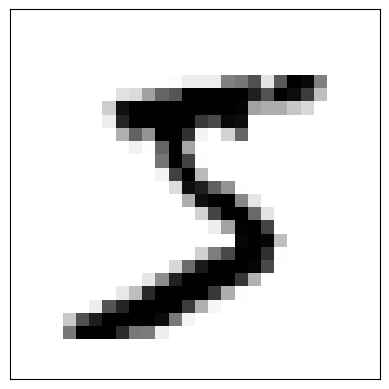

In [3]:
# Fetch one data pair (one image and the corresponding label)
image, label = train_data[0]
print(image.shape)
print('Image label :', label)

# You should note that the size of the image is [1, 28, 28], which corresponds to [num_channels, height, width]
# Indeed, MNIST images are in black and white so there is only 1 color channel.
# To plot this image, we need to remove this channel dimension by using squeeze()
plt.figure()
plt.imshow(image.squeeze(), cmap='gray_r')
plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
# TO DO:
# - create two dataloaders (for the training and testing subsets) with a batch size of 8
# - print the number of batches in the training subset

batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

print('Number of batches in the training subset:', len(train_dataloader))
print('Number of batches in the testing subset:', len(test_dataloader))


Number of batches in the training subset: 50
Number of batches in the testing subset: 7


In [5]:
# Get a batch of images and corresponding labels from the train dataloader
batch_example = next(iter(train_dataloader))
image_batch_example = batch_example[0]
labels_batch_example = batch_example[1]

# Print the size of the batch of images and labels
print(image_batch_example.shape)
print(labels_batch_example.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8])


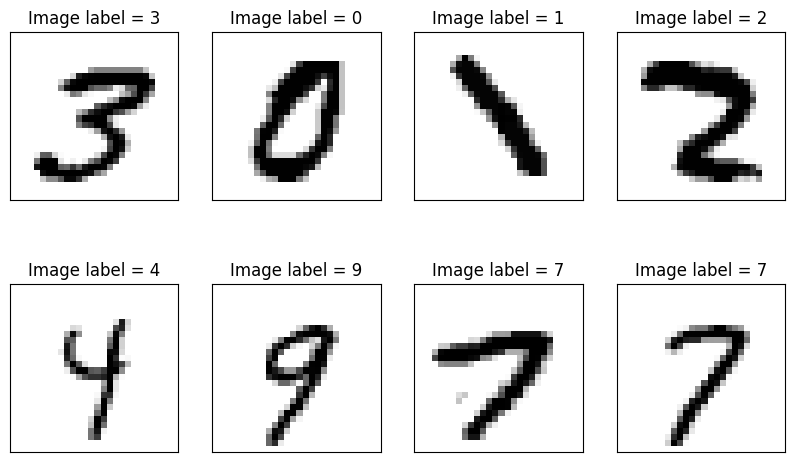

In [6]:
# Plot the images in the batch (along with the corresponding label)
plt.figure(figsize = (10,6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
plt.show()

## MLP network

A typical MLP network is composed of several layers:

- an *input* layer, which takes a batch of vectors and computes the first hidden representation.
- one or several *hidden* layers.
- an *output* layer, which computes the output of the network.

Each layer consists of a linear part and a non-linear *activation* functions (except for the output layer, which usually don't use an activation function). There are many non-linear activation functions in Pytorch, check the [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for a complete overview. A network is said to be *deep* if it has at least 3 layers (input, at least one hidden, and output).

<center><a href="https://www.researchgate.net/publication/309592737_Classification_of_VoIP_and_non-VoIP_traffic_using_machine_learning_approaches">
    <img src="https://www.researchgate.net/profile/Mouhammd-Alkasassbeh/publication/309592737/figure/fig2/AS:423712664100865@1478032379613/MultiLayer-Perceptron-MLP-sturcture-334-MultiLayer-Perceptron-Classifier-MultiLayer.png"></a></center>

**Note**: Since an MLP manipulates vectors (= 1D-tensors) as inputs, in image processing we first have to transform our images into vectors. For instance, if a black-and-white image is a (3D) tensor of size `[1, 28, 28]`, then we have to reshape it into a tensor of size `[1x28x28] = [784]`.


### Example

First, we will write a succession of operations which correspond to applying the MLP classifier on the example batch `image_batch_example`.

In [7]:
# TO DO: reshape the image_batch_example into a batch of vectors (vectorized images):
# 'image_batch_example' has size [batch_size, 1, 28, 28]
# 'vectorized_batch' should have size [batch_size, 1*28*28]

vectorized_batch = image_batch_example.view(batch_size, -1)
print(vectorized_batch.shape)

torch.Size([8, 784])


In [8]:
# Now we create the input layer (linear and activation) and we pass the vectorized batch to it
input_size = vectorized_batch.shape[-1]
hidden_size = 10
input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.Sigmoid())
y = input_layer(vectorized_batch)
print(y.shape)

torch.Size([8, 10])


In [9]:
# TO DO: create the two other layers (hidden_layer and output_layer):
# - the hidden layer goes from 'hidden_size' to 'hidden_size', and uses a Sigmoid activation function
# - the output layer goes from 'hidden_size' to 'output_size', which is the number of classes in the dataset (it uses no activation function)
# - Compute z = hidden_layer(y) and out=output_layer(z). Print the size of 'out'.

hidden_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.Sigmoid())
output_size = num_classes
output_layer = nn.Linear(hidden_size, output_size)
z = hidden_layer(y)
out = output_layer(z)

From what we have done above, two important remarks can be made:

- The output `out` has size `[batch_size, num_classes]` while the true labels `labels_batch_example` has size `[batch_size]`. This is because `out` contains a predicted probability for each class, while `labels_batch_example` simply contains the true labels.
- In classification tasks, we want to output probabilities per class. However, nothing ensures that `out` corresponds to probabilities, since it is not normalized and we didn't use any output activation function (values can be negative and not sum up to 1).

However, when training a classification network, we generally use the [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) loss function, which alleviates these two issues. This loss is optimized for handling true labels instead of true probabilities per class, so you don't have to worry about it. Besides, it will automatically apply a [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) non-linearity to the predicted outputs, in order to normalize them as probabilities per class.

**Note**: Instead of Cross Entropy, you can use the [Negative log-likelihood](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) similarly. It will also solve the first problem, but then you need to manually add a [log Softmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) as output activation to normalize the outputs.

In [10]:
# Choose Cross Entropy as loss function
loss_fn = nn.CrossEntropyLoss()

# Compute the error between the predicted labels 'out' and true labels 'labels_batch_example'
loss_batch = loss_fn(out, labels_batch_example)
print(loss_batch.item())

2.479875087738037


### General module

Now, let's create a general MLP classification network. It's a python class that inherits from the general `nn.Module` object, and it should contain at least 2 methods:

- `__init__`, which initializes the network when instanciated (creates all the layers and stores some useful parameters if needed).
- `forward`, which applies the forward pass (i.e., compute the output 'out' from the input and using the layers).

You can add other methods if needed but these two are sufficient for now.

**Note**: Remember that Python classes usually define and use some variables/data/tensors/dictionary etc. internally (this includes network layers) called *attributes*: they should be defined in the `__init__` method with a specific structure (the name should start by `self.`, as we did in lab 1). This allows you to access these attributes in other methods, or after defining your network.

In [11]:
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super(MLPClassif, self).__init__()
        
        # TO DO: define the input, hidden, and output layers as before
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size, bias=False), act_fn)
        self.hidden_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size), act_fn)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        
        # TO DO: write the 'forward' method, which computes the output 'out' from the input x
        # It should apply sequentially the input, hidden, and output layer, as we did in the example before.
        
        y = self.input_layer(x)
        z = self.hidden_layer(y)
        return self.output_layer(z)

In [12]:
# To DO: Instanciate an MLP classifier called 'model' with a hidden size of 10 and a Sigmoid activation function
model = MLPClassif(input_size, hidden_size, output_size, nn.Sigmoid())

In [13]:
# initialization (ensure reproducibility: everybody should have the same results)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

torch.manual_seed(0)
model.apply(init_weights)

MLPClassif(
  (input_layer): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=False)
    (1): Sigmoid()
  )
  (hidden_layer): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (output_layer): Linear(in_features=10, out_features=10, bias=True)
)

In [14]:
# You can save / load the model's parameters as follow:
# torch.save(model.state_dict(), 'model_mlp_classif.pt')
model.load_state_dict(torch.load('model_mlp_classif.pt'))

<All keys matched successfully>

In [15]:
# A useful command to get the total number of parameters in the model
print('Total number of parameters:', sum(p.numel() for p in model.parameters()))

Total number of parameters: 8060


<span style="color:red">**Q1**</span> How many parameters are in the network?

## Training

We now write the function for training the network. It's very similar to what we did in lab 2, except now we process batches of data instead of the whole dataset at each epoch.

In [16]:
def training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list for storing the training loss over epochs
    train_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        
        # Initialize the training loss for the current epoch
        tr_loss = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (size should be (batch_size, input_size))
            # - calculate the predicted labels from the vectorized images using 'model_tr'
            # - using loss_fn, calculate the 'loss' between the predicted and true labels
            # - set the optimizer gradients at 0 for safety
            # - compute the gradients (use the 'backward' method on 'loss')
            # - apply the gradient descent algorithm (perform a step of the optimizer)
            
            vectorized_images = images.view(images.shape[0], -1)
            predicted_labels = model_tr(vectorized_images)
            loss = loss_fn(predicted_labels, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the current epoch loss
            # Note that 'loss.item()' is the loss averaged over the batch, so multiply it with the current batch size to get the total batch loss
            tr_loss += loss.item() * images.shape[0]

        # At the end of each epoch, get the average training loss and store it
        tr_loss = tr_loss/len(train_dataloader.dataset)
        train_losses.append(tr_loss)
        
        # Display the training loss
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}'.format(epoch+1, num_epochs, tr_loss))
    
    return model_tr, train_losses

In [17]:
# TO DO: Define the training parameters and train the model
# - 30 epochs
# - learning rate = 0.01
# - loss function: Cross Entropy
# After training, save the model parameters and display the loss over epochs

num_epochs = 30
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
model_trained, train_losses = training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/30], Training loss: 2.3550
Epoch [2/30], Training loss: 2.3123
Epoch [3/30], Training loss: 2.2855
Epoch [4/30], Training loss: 2.2657
Epoch [5/30], Training loss: 2.2494
Epoch [6/30], Training loss: 2.2356
Epoch [7/30], Training loss: 2.2227
Epoch [8/30], Training loss: 2.2115
Epoch [9/30], Training loss: 2.2010
Epoch [10/30], Training loss: 2.1911
Epoch [11/30], Training loss: 2.1816
Epoch [12/30], Training loss: 2.1723
Epoch [13/30], Training loss: 2.1636
Epoch [14/30], Training loss: 2.1550
Epoch [15/30], Training loss: 2.1468
Epoch [16/30], Training loss: 2.1378
Epoch [17/30], Training loss: 2.1295
Epoch [18/30], Training loss: 2.1211
Epoch [19/30], Training loss: 2.1128
Epoch [20/30], Training loss: 2.1045
Epoch [21/30], Training loss: 2.0957
Epoch [22/30], Training loss: 2.0870
Epoch [23/30], Training loss: 2.0783
Epoch [24/30], Training loss: 2.0694
Epoch [25/30], Training loss: 2.0604
Epoch [26/30], Training loss: 2.0512
Epoch [27/30], Training loss: 2.0421
Epoch [28/

## Evaluation

Now the model is trained, we can evaluate it on the test dataset. We do that by predicting the labels using our model, and comparing it with the true labels. This allows us to compute the classification accuracy, which is provided in the function below.

In [18]:
# Evaluation function: similar to the training loop, except we don't need to compute any gradient / backprop

def eval_mlp_classifier(model, eval_dataloader):
    
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [19]:
# TO DO: Evaluate the model on the test set:
# - Instanciate an MLP newtork and load the trained parameters
# - Apply the evaluation function using the test dataloader
# - Print the test accuracy

model_test = MLPClassif(input_size, hidden_size, output_size, nn.Sigmoid())
model_test.load_state_dict(model_trained.state_dict())
accuracy = eval_mlp_classifier(model_test, test_dataloader)
print('Test accuracy: {:.2f}%'.format(accuracy))


Test accuracy: 68.00%


<span style="color:red">**Q2**</span> Put the plot above (training loss over epochs) and the test accuracy in your report. Based on the plot, can you suggest a way to improve the test accuracy?

To improve the test accuracy, we can try to change the amount of layers, the size of the dataset. We can also try to change the activation function.

## Influence of the activation function

We used the MLP classifier with a Sigmoid activation function, but another common choice is the [Rectified Linear Unit](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU). Here we investigate how it performs compared to the Sigmoid-based network.

In [20]:
# TO DO: Define an MLP classifier called 'model_relu' using a ReLU activation. 

model_relu = MLPClassif(input_size, hidden_size, output_size, nn.ReLU())

In [21]:
# Initialize the weights (for reproducibility)
torch.manual_seed(0)
model_relu.apply(init_weights)

MLPClassif(
  (input_layer): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=False)
    (1): ReLU()
  )
  (hidden_layer): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (output_layer): Linear(in_features=10, out_features=10, bias=True)
)

Epoch [1/30], Training loss: 2.2223
Epoch [2/30], Training loss: 1.8006
Epoch [3/30], Training loss: 1.3115
Epoch [4/30], Training loss: 0.8852
Epoch [5/30], Training loss: 0.6514
Epoch [6/30], Training loss: 0.5154
Epoch [7/30], Training loss: 0.4162
Epoch [8/30], Training loss: 0.3569
Epoch [9/30], Training loss: 0.3140
Epoch [10/30], Training loss: 0.2628
Epoch [11/30], Training loss: 0.2301
Epoch [12/30], Training loss: 0.1992
Epoch [13/30], Training loss: 0.1758
Epoch [14/30], Training loss: 0.1498
Epoch [15/30], Training loss: 0.1314
Epoch [16/30], Training loss: 0.1188
Epoch [17/30], Training loss: 0.1029
Epoch [18/30], Training loss: 0.0926
Epoch [19/30], Training loss: 0.0799
Epoch [20/30], Training loss: 0.0757
Epoch [21/30], Training loss: 0.0673
Epoch [22/30], Training loss: 0.0621
Epoch [23/30], Training loss: 0.0565
Epoch [24/30], Training loss: 0.0522
Epoch [25/30], Training loss: 0.0482
Epoch [26/30], Training loss: 0.0445
Epoch [27/30], Training loss: 0.0413
Epoch [28/

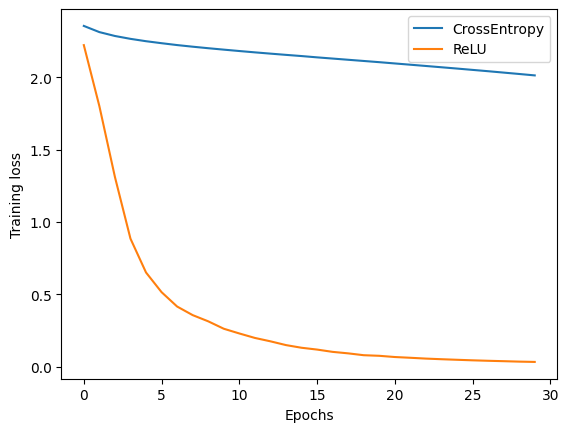

Test accuracy (ReLU): 86.00%


In [22]:
# TO DO: Train the network and evaluate it.

model_trained_relu, train_losses_relu = training_mlp_classifier(model_relu, train_dataloader, num_epochs, loss_fn, learning_rate)
accuracy_relu = eval_mlp_classifier(model_trained_relu, test_dataloader)
print('Test accuracy (ReLU): {:.2f}%'.format(accuracy_relu))

# Training, plot the loss and save the model's parameters

plt.figure()
plt.plot(train_losses, label='CrossEntropy')
plt.plot(train_losses_relu, label='ReLU')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()
plt.show()

# Evaluate on the test set and print accuracy

accuracy = eval_mlp_classifier(model_trained_relu, test_dataloader)
print('Test accuracy (ReLU): {:.2f}%'.format(accuracy))


<span style="color:red">**Q3**</span> What is the accuracy on the test set with this network? Which one (Sigmoid or ReLU) would you recommend to use?

Accuracy results :

- Sigmoid : 0.68
- ReLU : 0.86

I would recommend to use the ReLU activation function because it has a better accuracy.

## Increasing the model capacity

In order to improve performance, a straightforward approach is to increase the model capacity, i.e., increase the number of parameters. There are basically two ways to do so : either increase the number of neurons in each layer (*width*) of increase the total number of layers (*depth*). Let's focus here on width.

In [23]:
# TO DO: define, train and evalute an MLP classifier model with a variable hidden_size:
# - 'hidden_size' ranges in [3, 5, 10, 50]
# - the networks use ReLU activation, and training uses 30 epochs
# - for each hidden size, print the number of parameters and the test accuracy
# Remember to initialize the weights of the network after instanciating it for reproducibility.

hidden_sizes = [3, 5, 10, 50]
act_fn = nn.ReLU()
num_epochs = 30
learning_rate = 0.01

for hidden_size in hidden_sizes:
    model = MLPClassif(input_size, hidden_size, output_size, act_fn)
    torch.manual_seed(0)
    model.apply(init_weights)
    model_trained, _ = training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=False)
    accuracy = eval_mlp_classifier(model_trained, test_dataloader)
    print('Hidden size: {}, Number of parameters: {}, Test accuracy: {:.2f}%'.format(hidden_size, sum(p.numel() for p in model_trained.parameters()), accuracy))

Hidden size: 3, Number of parameters: 2404, Test accuracy: 46.00%
Hidden size: 5, Number of parameters: 4010, Test accuracy: 56.00%
Hidden size: 10, Number of parameters: 8060, Test accuracy: 86.00%
Hidden size: 50, Number of parameters: 42260, Test accuracy: 88.00%


<span style="color:red">**Q4**</span> Report the test accuracy as a function of `hidden_size`. Which value of `hidden_size` would you use and why?

Accuracy results :

- hidden_size = 3 : 0.46
- hidden_size = 5 : 0.56
- hidden_size = 10 : 0.86
- hidden_size = 50 : 0.88

I would use the hidden_size = 10 because it has a good accuracy and it's not too big, so it's not too heavy to compute.